In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns

# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
# License: BSD (3-clause)
from matplotlib.colors import TwoSlopeNorm

import os.path as op
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

from mne_connectivity import spectral_connectivity_epochs, seed_target_indices
from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity
from mne.stats import permutation_cluster_test
from scipy import stats as stats
from functools import partial

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
dict015= {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FT9':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg','FT10':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','TP9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','TP10':'eeg','P7':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_imp = {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','FT9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','FT10':'eeg','TP9':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_exp = dict015

dict011_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg','T7':'eeg','FT10':'eeg',
               'CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'FT9':'eeg', 'TP10':'eeg','P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg',
               'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
              'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict011_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FT10':'eeg', 'FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
               'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'TP9':'eeg', 'P8':'eeg','P4':'eeg','Pz':'eeg',
               'P3':'eeg','P7':'eeg','O2':'eeg', 'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs',
               'DBS6-7':'dbs','DBS7-8':'dbs', 'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}
           
    
#'DBS1-234':'dbs','DBS234-567':'dbs','DBS567-8':'dbs','mean(DBS1-234, DBS234-567, DBS567-8)':'dbs',

dict08_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',             
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict08_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FC6':'eeg', 'FC2':'eeg','FC1':'eeg','FC5':'eeg',
                'T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg', 'T7':'eeg','FT10':'eeg', 'CP6':'eeg','CP2':'eeg',
                'CP1':'eeg','CP5':'eeg','FT9':'eeg','TP10':'eeg', 'P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg',
                'O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',         
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_imp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',
                'DynR':'misc','DynL':'misc','DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_exp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P8':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict_eog= {'FP1':'eog'}

In [3]:
base_dir = "/mnt/beegfs/malann/codes/Oddball_Project/Oddball Data/"
result_dir = "/mnt/beegfs/malann/codes/Oddball_Project/Results/"

subj_list = ['007','008','011','013','014','015']
#subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard_E', 'Standard_NE', 'Oddball_E', 'Oddball_NE'];

naff_cond = ['10', '110'];
hand = 'aff'

tfrs_dbs_all = []
tfrs_all = []
epochs_aff_odd_all = []
epochs_aff_typ_all = []

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
        
        if hand == 'naff':
            fname = data_dir+"data_clean"+st+'_naff_cond.mat'
            dyno = 'DynR(lc)'
        else:
            fname = data_dir+"data_clean"+st+'.mat'
            dyno = 'DynL(lc)'          

                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']
        
        epochs.set_channel_types(dict1)

        kind='easycap-M1'
        mon = mne.channels.make_standard_montage(kind, head_size='auto')
        epochs.set_montage(mon,match_case=False, on_missing='ignore')
        
        #epochs.filter(0.05,30)

        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]
        
      
        epochs_aff_typ_E = epochs_aff_typ.copy()
        epochs_aff_typ_NE = epochs_aff_typ.copy()
        
        # calculate outlier trial
        tmax = 6
        Dynmo_odd = epochs_aff_odd.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd = Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2])
        
        t_target = int(200+200*1.5)
        #Calculate Error Rate
        ERR_value = []
        for i in range(len(Dynmo_odd)):
            ERR_value1 = ((Dynmo_odd[i,:].max()-Dynmo_odd[i,t_target])*100)/Dynmo_odd[i,t_target]
            ERR_value.append(ERR_value1)
        
        over_thres = 20
        
        outlier_idx=[]
        outlier_idx_odd_no_err=[]
        for j,m in enumerate(ERR_value):
            if (m>over_thres):
                outlier_idx.append(j)
            else:
                outlier_idx_odd_no_err.append(j)
        
        epochs_aff_odd_E=epochs_aff_odd[outlier_idx]
        epochs_aff_odd_NE=epochs_aff_odd[outlier_idx_odd_no_err]
        
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_E,epochs_aff_typ_E], method='truncate')
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_NE,epochs_aff_typ_NE], method='truncate')
        
       
        
        

        '''mne.epochs.equalize_epoch_counts([epochs_aff_odd,epochs_aff_typ], method='truncate')
        
        epochs_aff_odd.set_channel_types(dict_eog)
        epochs_aff_typ.set_channel_types(dict_eog)
 
        epochs_aff_odd_all.append(epochs_aff_odd)
        epochs_aff_typ_all.append(epochs_aff_typ)'''
        
        
        
        
        
        # TFR 
        
        tmin, tmax = -1.5, 4
        freqs = np.arange(1, 30)  # frequencies from 2-100Hz
        
        kwargs = dict(
            n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
        )  # for cluster test
        
        epochs_dbs = [epochs_aff_typ_E.copy().pick(['dbs']), epochs_aff_typ_NE.copy().pick(['dbs']), 
                      epochs_aff_odd_E.copy().pick(['dbs']), epochs_aff_odd_NE.copy().pick(['dbs'])]
        
        epochs = [epochs_aff_typ_E.copy().pick(['eeg']), epochs_aff_typ_NE.copy().pick(['eeg']), 
                  epochs_aff_odd_E.copy().pick(['eeg']), epochs_aff_odd_NE.copy().pick(['eeg'])]
        
        
        #del epochs_aff_typ, epochs_aff_odd
        
        tfrs = []
        for i, epoch in enumerate(epochs):
            
            """tfrs1 = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=5,average=False, return_itc=False)
            """
            """tfrs1 = tfr_multitaper(
                    epoch,
                    freqs=freqs,
                    n_cycles=7,
                    use_fft=True,
                    return_itc=False,
                    average=False,
                    decim=2,
                    n_jobs=50
                )"""

            tfrs1 = epoch.compute_tfr(
                method="morlet",
                freqs=freqs,
                n_cycles=freqs,
                use_fft=True,
                return_itc=False,
                average=False,
                decim=1,
                n_jobs=50
            )

            tfrs1.crop(tmin, tmax)

     
            if i == 0:
                fname = f'{result_dir}TFR_{sub}_{st}_standard_E'                
            elif i==1:
                fname = f'{result_dir}TFR_{sub}_{st}_standard_NE'
            elif i==2:
                fname = f'{result_dir}TFR_{sub}_{st}_oddball_E'
            elif i==3:
                fname = f'{result_dir}TFR_{sub}_{st}_oddball_NE'
            tfrs1.save(fname, overwrite=True, verbose=None)
        
            
        tfrs_dbs = []
        for i, epoch in enumerate(epochs_dbs):

            tfrs1_dbs = epoch.compute_tfr(
                method="morlet",
                freqs=freqs,
                n_cycles=freqs,
                use_fft=True,
                return_itc=False,
                average=False,
                decim=1,
                n_jobs=50
            )


            tfrs1_dbs.crop(tmin, tmax)
        
            if i == 0:
                fname = f'{result_dir}TFR_dbs_{sub}_{st}_standard_E'                
            elif i==1:
                fname = f'{result_dir}TFR_dbs_{sub}_{st}_standard_NE'
            elif i==2:
                fname = f'{result_dir}TFR_dbs_{sub}_{st}_oddball_E'
            elif i==3:
                fname = f'{result_dir}TFR_dbs_{sub}_{st}_oddball_NE'
            tfrs1_dbs.save(fname, overwrite=True, verbose=None)
                        
            
    #tfrs_dbs_all.append(tfrs_dbs)
    #tfrs_all.append(tfrs)

Adding metadata with 9 columns
404 matching events found
No baseline correction applied


/tmp/ipykernel_1090245/585778347.py:54: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, Pz, T7, T8, TP10, TP9, mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8) has changed from NA to V.
  epochs.set_channel_types(dict1)


Dropped 0 epochs: 
Dropped 103 epochs: 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146
Dropped 0 epochs: 
Dropped 143 epochs: 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 1

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:   17.1s remaining:  1.3min
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:   18.9s remaining:   30.5s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:   19.5s remaining:   13.7s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:   20.1s remaining:    5.2s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:   20.8s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    2.9s remaining:   13.4s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    2.9s remaining:    4.7s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    3.1s remaining:    2.1s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    5.9s remaining:    1.5s


Overwriting existing file.


[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    6.5s finished
/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    1.0s remaining:    4.7s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.8s remaining:    2.9s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    2.2s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    0.2s remaining:    0.0s


Overwriting existing file.


[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    0.2s finished
/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=50)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=50)]: Done  10 out of  10 | elapsed:    0.6s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=50)]: Done  10 out of  10 | elapsed:    0.1s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=50)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=50)]: Done  10 out of  10 | elapsed:    0.6s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=50)]: Done  10 out of  10 | elapsed:    0.1s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Adding metadata with 9 columns
431 matching events found
No baseline correction applied


/tmp/ipykernel_1090245/585778347.py:54: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, Pz, T7, T8, TP10, TP9, mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8) has changed from NA to V.
  epochs.set_channel_types(dict1)


Dropped 0 epochs: 
Dropped 105 epochs: 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152
Dropped 0 epochs: 
Dropped 151 epochs: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 1

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    1.2s remaining:    5.7s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.9s remaining:    3.1s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    2.1s remaining:    1.5s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    2.4s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    0.2s finished
/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    1.1s remaining:    5.3s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.9s remaining:    3.1s
[

Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    0.2s finished
/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=50)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.4s
[P

Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=50)]: Done  10 out of  10 | elapsed:    0.1s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=50)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.4s


Overwriting existing file.


[Parallel(n_jobs=50)]: Done  10 out of  10 | elapsed:    0.6s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=50)]: Done  10 out of  10 | elapsed:    0.1s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Adding metadata with 9 columns
600 matching events found
No baseline correction applied


/tmp/ipykernel_1090245/585778347.py:54: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P7, Pz, T7, T8, TP10, mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8) has changed from NA to V.
  epochs.set_channel_types(dict1)


Dropped 0 epochs: 
Dropped 172 epochs: 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221
Dropped 0 epochs: 
Dropped 194 epochs: 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    1.2s remaining:    5.7s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    2.3s remaining:    1.6s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    2.5s remaining:    0.6s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    2.6s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    0.8s remaining:    3.6s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    1.3s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    1.3s remaining:    6.0s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    2.0s remaining:    3.3s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    2.2s remaining:    1.5s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    2.5s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    0.6s remaining:    2.8s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    1.3s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.5s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.


Overwriting existing file.


[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.3s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.5s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.


Overwriting existing file.


[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.3s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Adding metadata with 9 columns
599 matching events found
No baseline correction applied


/tmp/ipykernel_1090245/585778347.py:54: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P8, Pz, T7, T8, TP9, mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8) has changed from NA to V.
  epochs.set_channel_types(dict1)


Dropped 0 epochs: 
Dropped 174 epochs: 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221
Dropped 0 epochs: 
Dropped 193 epochs: 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    1.2s remaining:    5.7s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.9s remaining:    3.0s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    2.2s remaining:    0.6s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    2.4s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    0.7s remaining:    3.4s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    1.2s remaining:    0.9s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    1.4s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    1.2s remaining:    5.7s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.9s remaining:    3.0s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    2.2s remaining:    0.6s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    2.3s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  34 | elapsed:    0.6s remaining:    3.0s
[Parallel(n_jobs=50)]: Done  13 out of  34 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=50)]: Done  20 out of  34 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=50)]: Done  27 out of  34 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=50)]: Done  34 out of  34 | elapsed:    1.4s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.6s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.


Overwriting existing file.


[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.3s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.6s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.


Overwriting existing file.


[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.3s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Adding metadata with 9 columns
494 matching events found
No baseline correction applied


/tmp/ipykernel_1090245/585778347.py:54: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P7, P8, Pz, T7, T8, TP10, TP9, mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8) has changed from NA to V.
  epochs.set_channel_types(dict1)


Dropped 0 epochs: 
Dropped 177 epochs: 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180
Dropped 0 epochs: 
Dropped 121 epochs: 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  36 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=50)]: Done  11 out of  36 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=50)]: Done  19 out of  36 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done  27 out of  36 | elapsed:    0.2s remaining:    0.1s


Overwriting existing file.


[Parallel(n_jobs=50)]: Done  36 out of  36 | elapsed:    0.2s finished
/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  36 | elapsed:    0.6s remaining:    6.9s
[Parallel(n_jobs=50)]: Done  11 out of  36 | elapsed:    2.5s remaining:    5.6s
[Parallel(n_jobs=50)]: Done  19 out of  36 | elapsed:    2.7s remaining:    2.4s
[Parallel(n_jobs=50)]: Done  27 out of  36 | elapsed:    2.9s remaining:    1.0s
[Parallel(n_jobs=50)]: Done  36 out of  36 | elapsed:    3.2s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  36 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=50)]: Done  11 out of  36 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=50)]: Done  19 out of  36 | elapsed:    0.2s remaining:    0.1s


Overwriting existing file.


[Parallel(n_jobs=50)]: Done  27 out of  36 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=50)]: Done  36 out of  36 | elapsed:    0.3s finished
/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  36 | elapsed:    0.7s remaining:    7.3s
[Parallel(n_jobs=50)]: Done  11 out of  36 | elapsed:    2.5s remaining:    5.6s
[Parallel(n_jobs=50)]: Done  19 out of  36 | elapsed:    2.7s remaining:    2.4s
[Parallel(n_jobs=50)]: Done  27 out of  36 | elapsed:    2.9s remaining:    1.0s
[Parallel(n_jobs=50)]: Done  36 out of  36 | elapsed:    3.2s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.1s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.7s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.1s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.7s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Adding metadata with 9 columns
445 matching events found
No baseline correction applied


/tmp/ipykernel_1090245/585778347.py:54: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P7, P8, Pz, T7, T8, TP10, TP9, mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8) has changed from NA to V.
  epochs.set_channel_types(dict1)


Dropped 0 epochs: 
Dropped 134 epochs: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143
Dropped 0 epochs: 
Dropped 102 epochs: 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 1

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  36 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=50)]: Done  11 out of  36 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=50)]: Done  19 out of  36 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=50)]: Done  27 out of  36 | elapsed:    0.4s remaining:    0.1s


Overwriting existing file.


[Parallel(n_jobs=50)]: Done  36 out of  36 | elapsed:    0.5s finished
/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  36 | elapsed:    0.6s remaining:    6.2s
[Parallel(n_jobs=50)]: Done  11 out of  36 | elapsed:    1.7s remaining:    3.9s
[Parallel(n_jobs=50)]: Done  19 out of  36 | elapsed:    1.9s remaining:    1.7s
[Parallel(n_jobs=50)]: Done  27 out of  36 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=50)]: Done  36 out of  36 | elapsed:    2.2s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  36 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=50)]: Done  11 out of  36 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=50)]: Done  19 out of  36 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=50)]: Done  27 out of  36 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=50)]: Done  36 out of  36 | elapsed:    0.5s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  36 | elapsed:    0.6s remaining:    6.1s
[Parallel(n_jobs=50)]: Done  11 out of  36 | elapsed:    1.7s remaining:    3.9s
[Parallel(n_jobs=50)]: Done  19 out of  36 | elapsed:    1.9s remaining:    1.7s
[Parallel(n_jobs=50)]: Done  27 out of  36 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=50)]: Done  36 out of  36 | elapsed:    2.2s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:169: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.1s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.4s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


Overwriting existing file.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.1s finished
/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_E) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)
[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=50)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=50)]: Done   8 out of   8 | elapsed:    0.5s finished


Overwriting existing file.


/tmp/ipykernel_1090245/585778347.py:197: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_NE) does not conform to MNE naming conventions. All time-frequency object files should end with .h5 or .hdf5
  tfrs1_dbs.save(fname, overwrite=True, verbose=None)


In [3]:
def average_bassline(tfr,comment,event_id):

    tfr_data = tfr.data
    tfr_norm1 =[]
    for ii,ch in enumerate(tfr.ch_names):
        x = np.hstack(tfr_data[:, ii, :, :]) # 3D dim = epoch* freq* time to 2D dim, freq * (time *epoch)
        x_mean=x.mean(axis=1) # mean of all the freqs across all the complete experiment session.
        tfr_norm=[]    
        for j in range(tfr_data[:, ii, :, :].shape[0]):
            tfr_norm.append(((tfr_data[j, ii, :, :].T-x_mean)/x_mean).T) # applying normalaization on each trail

        tfr_norm1.append(tfr_norm)
    tfr_norm1 = np.array(tfr_norm1)
    tfr_norm1 = np.rollaxis(tfr_norm1,1) # normalized tfr data
       
    return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id) 


In [4]:
subj_list = ['007','008','011','013','014','015']
#subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard_E', 'Standard_NE', 'Oddball_E', 'Oddball_NE']

naff_cond = ['10', '110'];
hand = 'aff'

tfrs_dbs_all = []
tfrs_all = []
epochs_aff_odd_all = []
epochs_aff_typ_all = []


conditions = ['standard_E', 'standard_NE', 'oddball_E', 'oddball_NE']
event_id_E = dict( Standard_E=1,Oddball_E=101)
event_id_NE = dict( Standard_NE=1,Oddball_NE=101)

tfrs_all = []
tfrs_dbs_all =[]
f_max_time = []

crop_min = -1.5
crop_max = 2

for sub in subj_list:
    for st in stage:
        
        
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        epochs_aff_odd = epochs[aff_cond[1]]
        f_max_time.append(np.argmax(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').reshape(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[0],epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[2]).mean(axis=0))/200)
       
        tfrs_all1=[]
        tfrs_dbs_all1 = []

        baseline = (-1.4,-0.4)
        mode = 'percent'
        baseline_avg =True
        
        for cond in conditions:
            
            if cond== 'standard_E' or cond== 'oddball_E':
                event_id = event_id_E
            elif cond== 'standard_NE' or cond== 'oddball_NE':
                event_id = event_id_NE
            
            
            if baseline_avg == True:
                fname = f'{result_dir}TFR_{sub}_{st}_{cond}'                
                tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))
                
                fname_dbs = f'{result_dir}TFR_dbs_{sub}_{st}_{cond}'
                tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))

            else:
                fname = f'{result_dir}TFR_{sub}_{st}_{cond}'                
                tfrs_all1.append(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max).apply_baseline(baseline,mode=mode))
                
                fname_dbs = f'{result_dir}TFR_dbs_{sub}_{st}_{cond}'
                tfrs_dbs_all1.append(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max).apply_baseline(baseline,mode=mode))
              
    tfrs_all.append(tfrs_all1)
    tfrs_dbs_all.append(tfrs_dbs_all1)
            

Adding metadata with 9 columns
404 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_E ...


/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_007_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_007_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
431 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_E ...


/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_008_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_008_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
600 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_E ...


/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_011_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_011_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
599 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_E ...


/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_013_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_013_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
494 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_E ...


/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_014_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_014_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
445 matching events found
No baseline correction applied
Reading /mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_E ...


/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_E ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:77: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_015_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading /mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_NE ...


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
/tmp/ipykernel_1025141/2764838154.py:80: RuntimeWarning: This filename (/mnt/beegfs/malann/Oddball Data/TFR_dbs_015_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


/tmp/ipykernel_1025141/424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


In [12]:
tfr_diff_avg_resp1.data.shape

(1, 29, 501)

# Plot EEG ERDS

/tmp/ipykernel_1025141/1645571099.py:22: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_typ_avg = mne.time_frequency.AverageTFR(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1025141/1645571099.py:27: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_odd_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1025141/1645571099.py:22: FutureWarning: Parameters "info", "

1
2
3
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


/tmp/ipykernel_1025141/1645571099.py:91: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_avg_resp1 = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_odd_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1025141/1645571099.py:94: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_typ_avg_resp1.copy().crop(crop_min,cropm_max).plot(
/tmp/ipykernel_1025141/1645571099.py:102: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_odd_avg_resp1.copy().crop(crop_min,cropm_max).plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

/tmp/ipykernel_1025141/1645571099.py:37: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_typ_avg = mne.time_frequency.AverageTFR(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1025141/1645571099.py:42: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_odd_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1025141/1645571099.py:37: FutureWarning: Parameters "info", "

1
2
3
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


/tmp/ipykernel_1025141/1645571099.py:91: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd_avg_resp1 = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_odd_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1025141/1645571099.py:94: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_typ_avg_resp1.copy().crop(crop_min,cropm_max).plot(
/tmp/ipykernel_1025141/1645571099.py:102: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_odd_avg_resp1.copy().crop(crop_min,cropm_max).plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

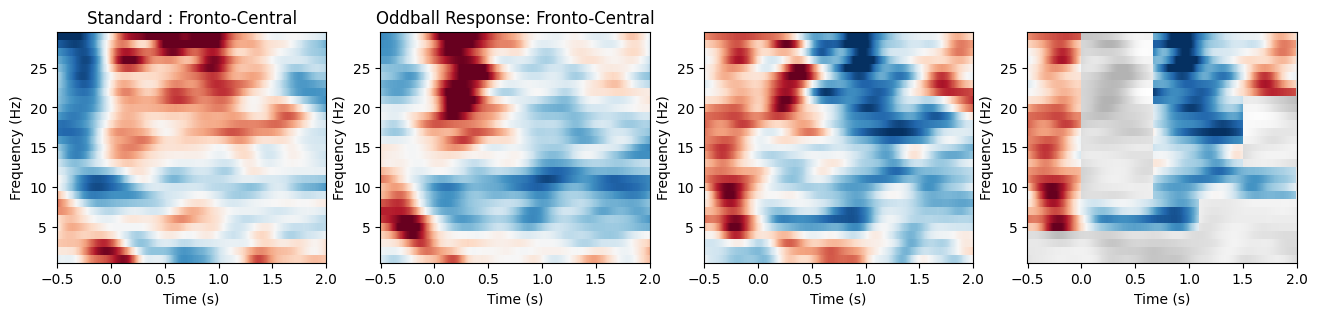

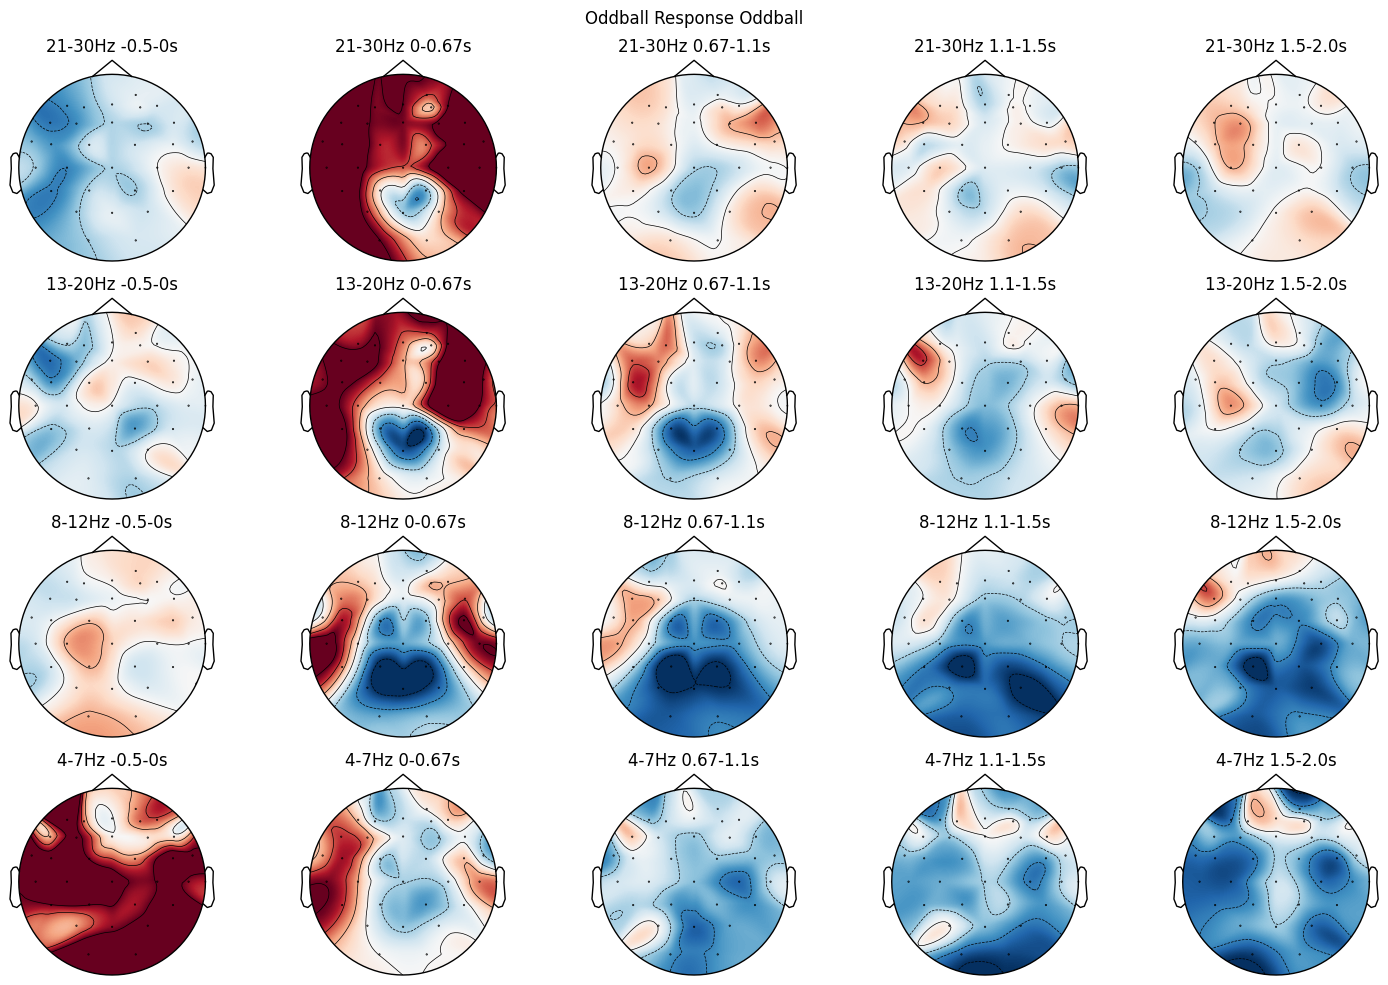

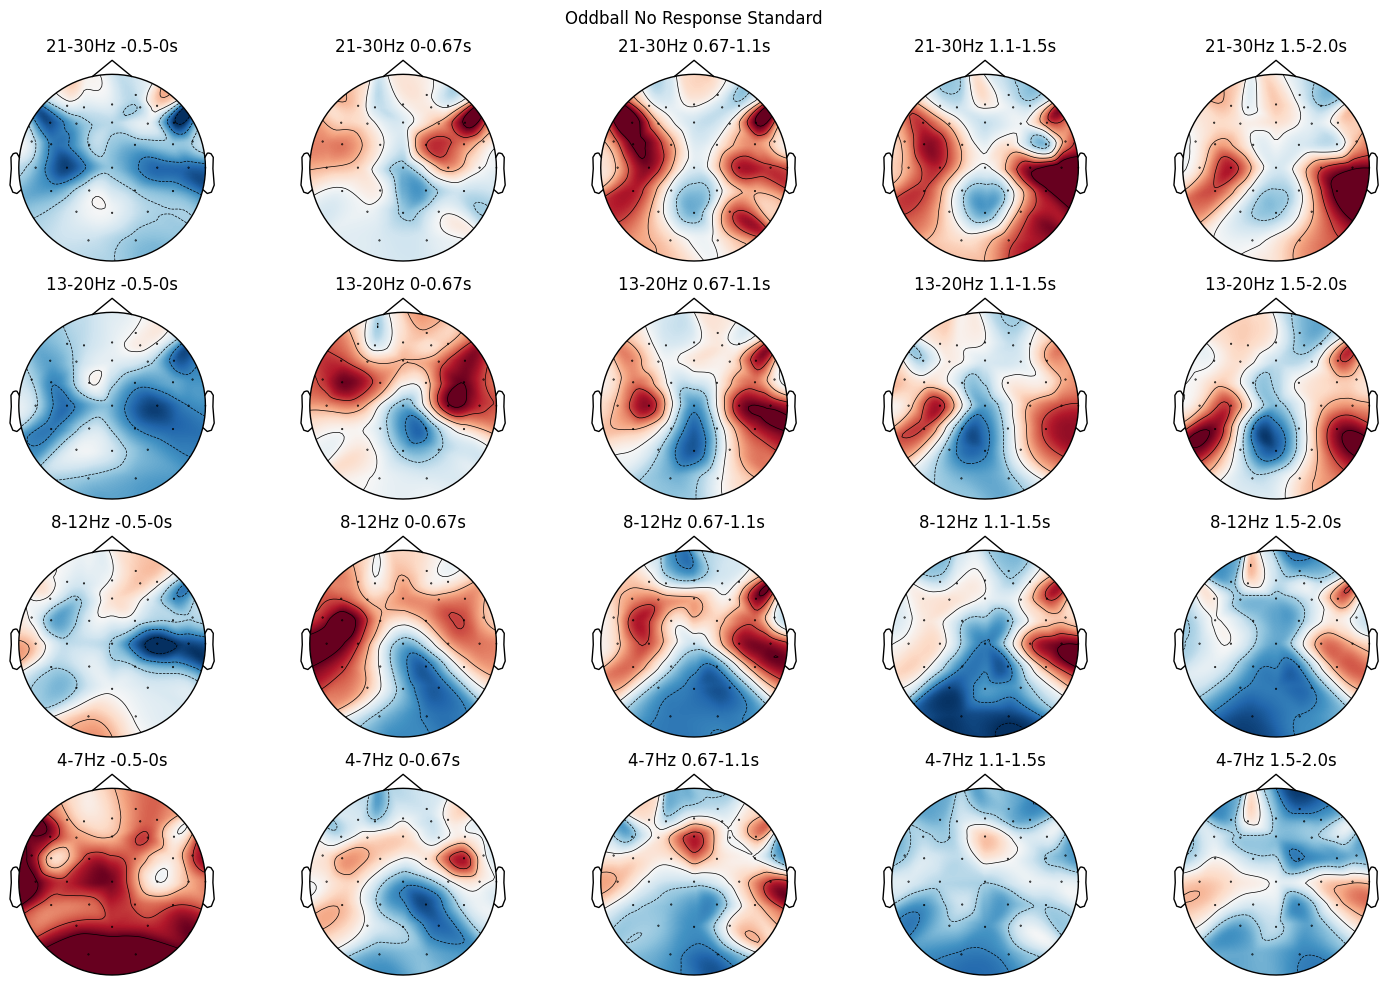

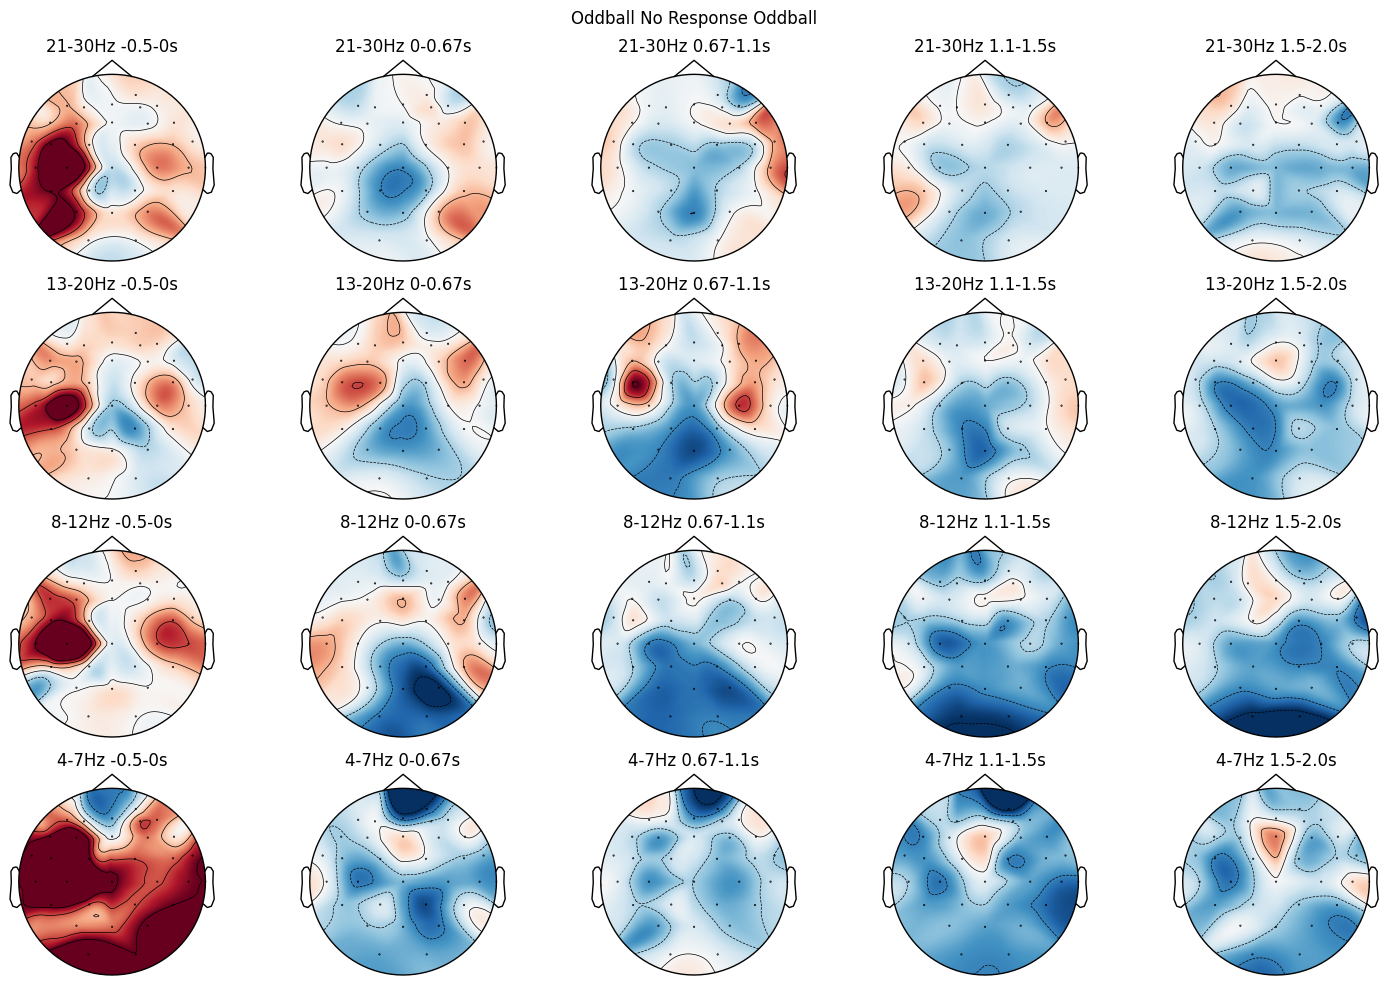

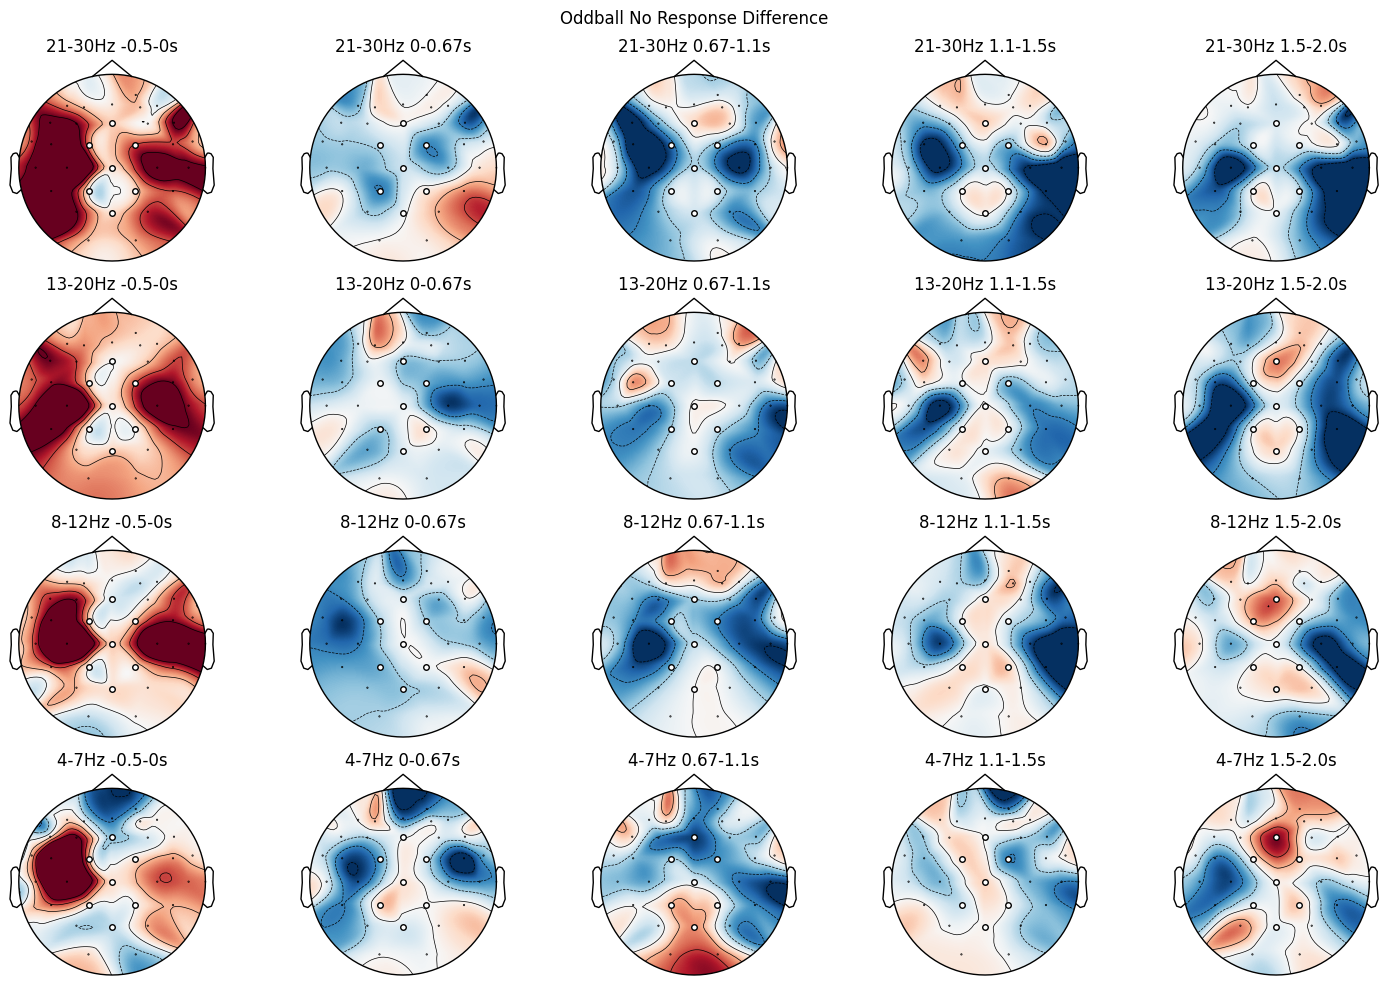

In [126]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'011':2,'013':3,'014':4,'015':5}
event_id = dict( Standard=1,Oddball=101)
ch_picks = ['FP2', 'AF8',  'AF4', 'AFz', 'AF3', 'AF7', 'F8', 'F4', 'Fz', 'F3', 'F7', 'FT10', 'FC6', 'FC2', 'FC1', 'FC5', 'FT9',
            'T8', 'C4', 'Cz', 'C3', 'T7', 'CP6', 'CP2', 'CP1', 'CP5', 'P4', 'Pz', 'P3', 'O2', 'O1']

task_res = ['Oddball Response', 'Oddball No Response']
tfr_typ_data_E = []
tfr_typ_data_NE = []
tfr_odd_data_E = []
tfr_odd_data_NE = []

for ires, res in enumerate(task_res):
    if res == 'Oddball Response':
        resp_idx = list(resp.values())
        
        tfr_typ_avg = []
        tfr_odd_avg = []
        for i in resp_idx:
            tfr_typ_data_E.append(tfrs_all[i][0].copy().pick(ch_picks).get_data())
            tfr_avg = tfrs_all[i][0].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_typ_avg = mne.time_frequency.AverageTFR(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
            tfr_typ_avg.append(tfrs_typ_avg)
            
            tfr_odd_data_E.append(tfrs_all[i][2].copy().pick(ch_picks).get_data())
            odd_avg = tfrs_all[i][2].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_odd_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
            tfr_odd_avg.append(tfrs_odd_avg)

    else:
        resp_idx = list(non_resp.values())
        tfr_typ_avg = []
        tfr_odd_avg = []
        for i in resp_idx:
            tfr_typ_data_NE.append(tfrs_all[i][1].copy().pick(ch_picks).get_data())
            tfr_avg = tfrs_all[i][1].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_typ_avg = mne.time_frequency.AverageTFR(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
            tfr_typ_avg.append(tfrs_typ_avg)
            
            tfr_odd_data_NE.append(tfrs_all[i][3].copy().pick(ch_picks).get_data())
            odd_avg = tfrs_all[i][3].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_odd_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
            tfr_odd_avg.append(tfrs_odd_avg)    


    if baseline_avg ==True:
        vmin, vmax = -0.3, 0.3  # set min and max ERDS values in plot
    else:
        vmin, vmax = -100, 100  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
    tfr_typ_avg_resp = tfr_typ_avg[0]
    for i in range(1, len(tfr_typ_avg)):
        print(i)
        tfr_typ_avg_resp += tfr_typ_avg[i]
    tfr_typ_avg_resp = tfr_typ_avg_resp/(i+1)
        
    tfr_odd_avg_resp = tfr_odd_avg[0]
    for i in range(1, len(tfr_odd_avg)):
        tfr_odd_avg_resp += tfr_odd_avg[i]
    tfr_odd_avg_resp = tfr_odd_avg_resp/(i+1)
    
    tfr_diff_avg_resp=tfr_odd_avg_resp-tfr_typ_avg_resp

    
# Channel to plot from average
    ch_plot = 'CP2'
    ch_plot_name = ch_plot
    fig, axes = plt.subplots(1,4, figsize = (16,3))

    avg = True
    region = 'FC'
    
    if avg==True:
        if region == 'FC':
            ch_picks_ipsi =['FC2','FC1','Cz','Fz']
            ch_plot_name = 'Fronto-Central'
        elif region == 'CP':
            ch_picks_ipsi =['CP2','CP1','Cz','Pz']
            ch_plot_name = 'Centro-Parietal'
        elif region == 'ipsi':
            ch_picks_ipsi =['FC6','C4','FC2']
            ch_plot_name = 'Ipsilesional'
            
        tfr_typ_avg_resp1 = tfr_typ_avg_resp.copy().pick(ch_picks_ipsi).get_data().mean(axis=0)
        tfr_typ_avg_resp1 = tfr_typ_avg_resp1.reshape(1,tfr_typ_avg_resp1.shape[0],tfr_typ_avg_resp1.shape[1])
        tfr_typ_avg_resp1 = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_typ_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
        
        tfr_odd_avg_resp1 = tfr_odd_avg_resp.copy().pick(ch_picks_ipsi).get_data().mean(axis=0)
        tfr_odd_avg_resp1 = tfr_odd_avg_resp1.reshape(1,tfr_odd_avg_resp1.shape[0],tfr_odd_avg_resp1.shape[1])
        tfr_odd_avg_resp1 = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_odd_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)

        crop_min,cropm_max = -0.5,2.0
        tfr_typ_avg_resp1.copy().crop(crop_min,cropm_max).plot(
                            ch_picks[0],
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[0],
                            mask_style="mask",
                            show=False,
                        )
        tfr_odd_avg_resp1.copy().crop(crop_min,cropm_max).plot(
                            ch_picks[0],
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[1],
                            mask_style="mask",
                            show=False                )

        tfr_diff_avg_resp1=tfr_odd_avg_resp1.copy().crop(crop_min,cropm_max)-tfr_typ_avg_resp1.copy().crop(crop_min,cropm_max)
        
        tfr_diff_avg_resp1.plot(
                            ch_picks[0],
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[2],
                            show=False                )

        tmin_mark = f_max_time_avg
        tmax_mark = 1.1
        fmin_mark = 4
        fmax_mark = 30
        
        mask_tfr_diff = np.full(tfr_diff_avg_resp1.data.shape, False)
        
        if region == 'FC':
        
            mask_tfr_diff[0,4:8,int((0-crop_min)*200):int((tmin_mark-crop_min)*200)]= True
            mask_tfr_diff[0,4:30,int((tmin_mark-crop_min)*200):int((tmax_mark-crop_min)*200)]= True
            mask_tfr_diff[0,8:30,int((tmax_mark-crop_min)*200):int((1.5-crop_min)*200)]= True
            mask_tfr_diff[0,8:12,int((1.5-crop_min)*200):int((2-crop_min)*200)]= True
    
            mask_tfr_diff[0,4:30,int((-0.5-crop_min)*200):int((0-crop_min)*200)]= True
            mask_tfr_diff[0,21:30,int((1.5-crop_min)*200):int((2-crop_min)*200)]= True

        elif region == 'CP':
            
            mask_tfr_diff[0,4:12,int((tmin_mark-crop_min)*200):int((tmax_mark-crop_min)*200)]= True
            mask_tfr_diff[0,21:30,int((tmin_mark-crop_min)*200):int((tmax_mark-crop_min)*200)]= True
            mask_tfr_diff[0,8:12,int((tmax_mark-crop_min)*200):int((1.5-crop_min)*200)]= True
    
            mask_tfr_diff[0,4:30,int((-0.5-crop_min)*200):int((0-crop_min)*200)]= True
            mask_tfr_diff[0,21:30,int((1.5-crop_min)*200):int((2-crop_min)*200)]= True     

        
        
        tfr_diff_avg_resp1.plot(
                            ch_picks[0],
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[3],
                            mask_style="mask",
                            mask =mask_tfr_diff[0,:,:],
                            mask_alpha=0.3,
                            show=False                )

        axes[0].set_title(f'Standard : {ch_plot_name}')
        axes[1].set_title(f'{res}: {ch_plot_name}')
  

    
    else:


        tfr_typ_avg_resp.copy().crop(crop_min,cropm_max).plot(
                            ch_plot,
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[0],
                            mask_style="mask",
                            show=False,
                        )
        
        tfr_odd_avg_resp.copy().crop(crop_min,cropm_max).plot(
                            ch_plot,
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[1],
                            mask_style="mask",
                            show=False                )

    
        axes[0].set_title(f'Standard : {ch_plot_name}')
        axes[1].set_title(f'{res}: {ch_plot_name}')
    
    
    fmins = [21,13,8,4]
    fmaxs = [30,20,12,7]
        
    f_max_time_avg = round((sum(f_max_time)/len(f_max_time)),2)
    tmins = [-0.5, 0, f_max_time_avg , 1.1, 1.5]
    tmaxs = [0, f_max_time_avg, 1.1, 1.5, 2.0]
    fig1, axes1_row = plt.subplots(len(fmins),len(tmins),figsize=(15,10))
    fig2, axes2_row = plt.subplots(len(fmins),len(tmins),figsize=(15,10))
    fig3, axes3_row = plt.subplots(len(fmins),len(tmins),figsize=(15,10))

    for axes1, fmin,fmax in zip(axes1_row, fmins,fmaxs):
        for tmin,tmax,ax1 in zip(tmins,tmaxs,axes1):
            tfr_typ_avg_resp.plot_topomap(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax,axes=ax1,show=False,vlim=(vmin,vmax),colorbar=False)
            ax1.set_title(f'{fmin}-{fmax}Hz {tmin}-{tmax}s')
    fig1.suptitle(f'{res} Standard')
    fig1.tight_layout()
    for axes2, fmin,fmax in zip(axes2_row, fmins,fmaxs):
        for tmin,tmax,ax2 in zip(tmins,tmaxs,axes2):
            tfr_odd_avg_resp.plot_topomap(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax,axes=ax2,show=False,vlim=(vmin,vmax),colorbar=False)
            ax2.set_title(f'{fmin}-{fmax}Hz {tmin}-{tmax}s')
    fig2.suptitle(f'{res} Oddball')
    fig2.tight_layout()

    roi_ch = ['FC2','FC1','Cz','Fz','CP2','CP1','Pz']
    
    mask_ch = np.full(len(tfr_diff_avg_resp.ch_names), False)
    
    for ich, ch in enumerate(tfr_diff_avg_resp.ch_names):
        if ch in roi_ch:
            mask_ch[ich] = True
    mask_ch
    
    for axes3, fmin,fmax in zip(axes3_row, fmins,fmaxs):
        for tmin,tmax,ax3 in zip(tmins,tmaxs,axes3):
            tfr_diff_avg_resp.plot_topomap(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax,axes=ax3,show=False,vlim=(vmin,vmax),colorbar=False,mask=mask_ch)
            ax3.set_title(f'{fmin}-{fmax}Hz {tmin}-{tmax}s')
    fig3.suptitle(f'{res} Difference')
    fig3.tight_layout()


No baseline correction applied


[<Figure size 640x480 with 1 Axes>]

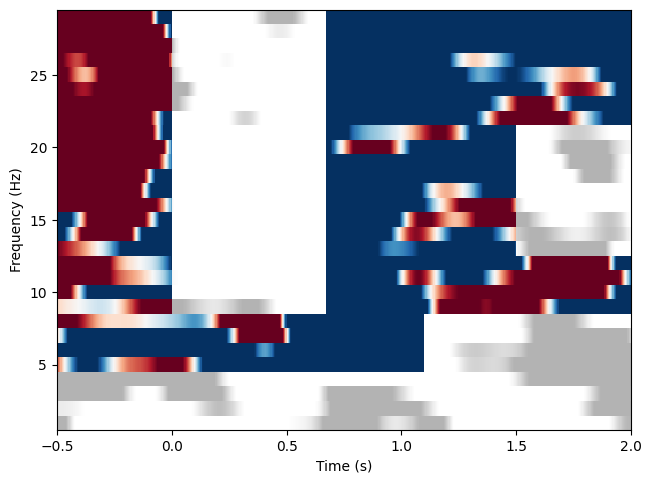

In [131]:
tfr_diff_avg_resp1.plot(
                    ch_picks[0],
                    colorbar=False,
                    vlim=(0,0.05),
                    mask_style="mask",
                    mask =mask_tfr_diff[0,:,:],
                    mask_alpha=0.3,
                    show=False                )

In [123]:
roi_ch = ['FC2','FC1','Cz','Fz','CP2','CP1','Pz']

mask_ch = np.full(len(tfr_diff_avg_resp.ch_names), False)

for ich, ch in enumerate(tfr_diff_avg_resp.ch_names):
    if ch in roi_ch:
        mask_ch[ich] = True
mask_ch

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False,  True, False, False, False,  True,  True, False, False,
        True, False, False, False])

In [48]:
fmin_mark and n<fmax_mark and m > (tmin_mark-crop_min)*200 and m < (tmax_mark-crop_min)*200

-0.5

In [90]:
tmin_mark = -0.5
tmax_mark = 1.1
fmin_mark = 1
fmax_mark = 12

mask_tfr_diff = np.full(tfr_diff_avg_resp1.data.shape, False)

mask_tfr_diff[0,4:30,int((tmin_mark-crop_min)*200):int((tmax_mark-crop_min)*200)]= True


In [91]:
tfr_diff_avg_resp1.data.shape

(1, 29, 501)

In [92]:
mask_tfr_diff[0,:,:]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

# Plot DBS ERDS 

In [7]:
dbs_chs = {'015':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'014':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'013':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'011':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'008':'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)',
'007':'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)'
}

In [36]:
dbs_chs = {'015':'DBS6-7',
'014':'DBS3-4',
'013':'DBS7-8',
'011':'DBS1-2',
'008':'DBS3-6',
'007':'DBS3-6'
}

/tmp/ipykernel_1090245/3164857011.py:23: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][0].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][0].times, tfrs_dbs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1090245/3164857011.py:31: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][2].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][2].times, tfrs_dbs_all[i][2].freqs,comment=aff_cond_plot[2],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1090245/3

1
2
3
No baseline correction applied
No baseline correction applied
No baseline correction applied


/tmp/ipykernel_1090245/3164857011.py:23: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][0].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][0].times, tfrs_dbs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1090245/3164857011.py:31: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][2].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][2].times, tfrs_dbs_all[i][2].freqs,comment=aff_cond_plot[2],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1090245/3

1
2
3
4
No baseline correction applied
No baseline correction applied
No baseline correction applied


/tmp/ipykernel_1090245/3164857011.py:48: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][3].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][3].times, tfrs_dbs_all[i][3].freqs,comment=aff_cond_plot[3],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1090245/3164857011.py:41: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][1].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][1].times, tfrs_dbs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
/tmp/ipykernel_1090245/3

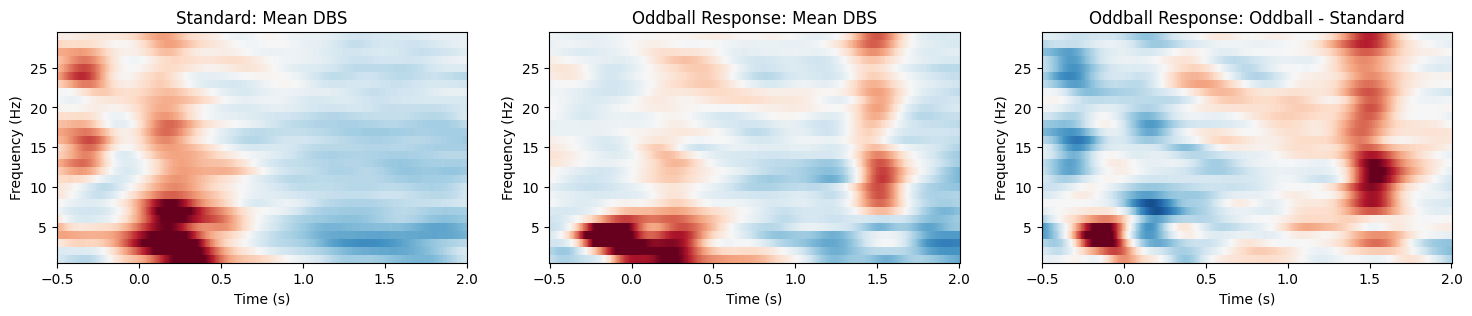

In [8]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'008':1,'011':2,'013':3,'014':4,'015':5}

task_res = ['Oddball Response', 'Oddball No Response'] 
for ires, res in enumerate(task_res):
    if res == 'Oddball Response':
        resp_idx = list(resp.values())
    else:
        resp_idx = list(non_resp.values())
        
    tfr_dbs_typ_avg = []
    tfr_dbs_odd_avg = []
  
    for i_idx, i in enumerate(resp_idx):

        if res == 'Oddball Response':
            ch_picks = tfrs_dbs_all[i][0].copy().pick(dbs_chs[list(resp.keys())[i_idx]]).ch_names
    
            tfr_dbs_avg1 = tfrs_dbs_all[i][0].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #tfr_dbs_avg1 = (tfr_dbs_avg1-tfr_dbs_avg1.min())/(tfr_dbs_avg1.max()-tfr_dbs_avg1.min()) 
            tfr_dbs_avg = tfr_dbs_avg1.reshape(1,tfr_dbs_avg1.shape[0],tfr_dbs_avg1.shape[1])
    
            tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][0].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][0].times, tfrs_dbs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
            tfr_dbs_typ_avg.append(tfrs_dbs_typ_avg)
        
            odd_dbs_avg1 = tfrs_dbs_all[i][2].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #odd_dbs_avg1 = (odd_dbs_avg1-odd_dbs_avg1.min())/(odd_dbs_avg1.max()-odd_dbs_avg1.min()) 
            odd_dbs_avg = odd_dbs_avg1.reshape(1,odd_dbs_avg1.shape[0],odd_dbs_avg1.shape[1])
    
            
            tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][2].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][2].times, tfrs_dbs_all[i][2].freqs,comment=aff_cond_plot[2],events=epochs.events,event_id=event_id)
            tfr_dbs_odd_avg.append(tfrs_dbs_odd_avg)
       
        else:
            ch_picks = tfrs_dbs_all[i][1].copy().pick(dbs_chs[list(non_resp.keys())[i_idx]]).ch_names

            tfr_dbs_avg1 = tfrs_dbs_all[i][1].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #tfr_dbs_avg1 = (tfr_dbs_avg1-tfr_dbs_avg1.min())/(tfr_dbs_avg1.max()-tfr_dbs_avg1.min()) 
            tfr_dbs_avg = tfr_dbs_avg1.reshape(1,tfr_dbs_avg1.shape[0],tfr_dbs_avg1.shape[1])
    
            tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][1].copy().pick(dbs_chs['015']).info, tfr_dbs_avg, tfrs_dbs_all[i][1].times, tfrs_dbs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
            tfr_dbs_typ_avg.append(tfrs_dbs_typ_avg)
        
            odd_dbs_avg1 = tfrs_dbs_all[i][3].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #odd_dbs_avg1 = (odd_dbs_avg1-odd_dbs_avg1.min())/(odd_dbs_avg1.max()-odd_dbs_avg1.min()) 
            odd_dbs_avg = odd_dbs_avg1.reshape(1,odd_dbs_avg1.shape[0],odd_dbs_avg1.shape[1])
    
            tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[2][3].copy().pick(dbs_chs['015']).info, odd_dbs_avg, tfrs_dbs_all[i][3].times, tfrs_dbs_all[i][3].freqs,comment=aff_cond_plot[3],events=epochs.events,event_id=event_id)
            tfr_dbs_odd_avg.append(tfrs_dbs_odd_avg)



    
    
    vmin, vmax = -1, 1  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
    tfr_dbs_typ_avg_resp = tfr_dbs_typ_avg[0]
    for i in range(1, len(tfr_dbs_typ_avg)):
        print(i)
        tfr_dbs_typ_avg_resp += tfr_dbs_typ_avg[i]
    tfr_dbs_typ_avg_resp = tfr_dbs_typ_avg_resp/(i+1)
    
    
    tfr_dbs_odd_avg_resp = tfr_dbs_odd_avg[0]
    for i in range(1, len(tfr_dbs_odd_avg)):
        tfr_dbs_odd_avg_resp += tfr_dbs_odd_avg[i]
    tfr_dbs_odd_avg_resp = tfr_dbs_odd_avg_resp/(i+1)
       
    fig, axes = plt.subplots(1,3, figsize = (18,3))
    tfr_dbs_typ_avg_resp.copy().crop(crop_min,cropm_max).plot(
                        dbs_chs['015'],
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[0],
                        mask_style="mask",
                        show=False
                    )
    tfr_dbs_odd_avg_resp.copy().crop(crop_min,cropm_max).plot(
                        dbs_chs['015'],
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[1],
                        mask_style="mask",
                        show=False          )
    
    tfr_dbs_diff_avg_resp=tfr_dbs_odd_avg_resp-tfr_dbs_typ_avg_resp
    tfr_dbs_diff_avg_resp.copy().crop(crop_min,cropm_max).plot(
                        dbs_chs['015'],
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[2],
                        mask_style="mask",
                        show=False,
                    )
    axes[0].set_title(f'Standard: Mean DBS')
    axes[1].set_title(f'{res}: Mean DBS')
    axes[2].set_title(f'{res}: Oddball - Standard')

# Excel Sheet of ERDS

In [9]:
f_max_time[0]

0.58

In [6]:
subj_list = ['007','008','011','013','014','015']

for i, (sub, tfr_all) in enumerate(zip(subj_list, tfrs_all)):
    
    if subj_list == ['013'] or subj_list == ['014'] or subj_list == ['015']:
        ch_picks =['F8','FC2','FC6','C4','CP2','CP6','Cz']
    else:
        ch_picks =['Fz','F4','FC6','FC2','C4','CP6','CP2','Cz']
    ch_picks = ['FC2','FC1','Cz','Fz','CP2','CP1','Pz','FC6','C4']       


    df1 = tfrs_all[i][0].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)
    df2 = tfrs_all[i][1].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)
    df3 = tfrs_all[i][2].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)
    df4 = tfrs_all[i][3].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)

    df5 = tfrs_dbs_all[i][0].to_data_frame(time_format=None, long_format=True)
    df6 = tfrs_dbs_all[i][1].to_data_frame(time_format=None, long_format=True)
    df7 = tfrs_dbs_all[i][2].to_data_frame(time_format=None, long_format=True)
    df8 = tfrs_dbs_all[i][3].to_data_frame(time_format=None, long_format=True)

    frames = [df1, df2, df3, df4, df5, df6, df7, df8]
    df = pd.concat(frames)
    # Map to frequency bands:
    freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
    time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time[i]} ]': f_max_time[i], f'[{f_max_time[i]} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}


    df["band"] = pd.cut(
        df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
    )

    df["Time_dur"] = pd.cut(
        df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
    )

    # Filter to retain only relevant frequency bands:
    freq_bands_of_interest = [ "[4 7]","[8 12]", "[13 20]", "[21 30]"]
    time_of_interest = ["[-0.5 0]", f'[0 {f_max_time[i]} ]', f'[{f_max_time[i]} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

    df = df[df.band.isin(freq_bands_of_interest)]
    df = df[df.Time_dur.isin(time_of_interest)]

    df["band"] = df["band"].cat.remove_unused_categories()
    df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()


    df_mean = (
        df.groupby(["condition", "Time_dur", "band", "channel"], observed=False)[["value"]]
        .mean()
        .reset_index()
    )
    df_mean.insert(0,'Stage', len(df_mean)*[st])
    df_mean.insert(1,'Subject', len(df_mean)*[sub])

    header = ["Stage", "Subject", "Condition", "Time", "Freq",'Channel', "ERDS"]
    if i == 0:
        df_mean.to_csv(result_dir+'Oddball_ERDS_E_NE2.csv', mode='a', index=False, header=header)
    else:
        df_mean.to_csv(result_dir+'Oddball_ERDS_E_NE2.csv', mode='a', index=False, header=False)


Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "